## Este notebook trata da criação de um único dataframe com base nos dataframes dos itensTG, da TEC e do Secta
## Serão criados três dataframes conforme abaixo:
### 1 - Dataframe com descrição limpa (com stopwords e com afixos)
### 2 - Dataframe com descrição limpa, sem stopwords (com afixos)
### 3 - Dataframe com descrição limpa, sem stopwords e radicais das palavras (stemming)

In [1]:
import pandas as pd
import numpy as np
import random
import os 
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from collections import namedtuple
from typing import Dict


## 1 - Dataframe com descrição limpa (com stopwords e com afixos)

### 1.1 - Carrega os dataframes

In [2]:
# Carrega os dataframes
df_itens = pd.read_parquet('1_itenstg_desc_limpa.parquet')
df_tec = pd.read_parquet('2_tec_desc_limpa.parquet')
df_secta = pd.read_parquet('3_secta_desc_limpa.parquet')

### 1.2 Como o dataframe do Secta é muito grande, vamos selecionar amostras aleatórias. Utilizamos o random_state como seed para garantir que seja reproduzido o mesmo resultado sempre.

In [3]:
len(df_secta)

174793

In [4]:
# cria um dataframe com distribuição uniforme
# df_secta = df_secta.groupby('capitulo', group_keys=False).apply(lambda x: x.sample(min(len(x), 200)))

# recria o df_secta com 10 mil linhas aleatórias - usando semente = 1
df_secta = df_secta.sample(n=10_000, random_state=1)

In [5]:
df_secta.capitulo.value_counts()

85    4213
84    1212
33     910
22     682
95     517
      ... 
54       1
31       1
05       1
10       1
97       1
Name: capitulo, Length: 69, dtype: int64

In [6]:
len(df_secta)

10000

### 1.3 - concatena os dataframes

In [7]:
# concatena os dataframes
itens = pd.concat([df_itens, df_tec, df_secta])

In [8]:
# tamanho do dataframe 'itens'
len(itens)

26115

In [9]:
# Duplicar linhas com somente 1 ou 2 exemplos
itens = itens.append(itens[itens['capitulo'].map(itens['capitulo'].value_counts()) <= 2])

In [10]:
itens.head()

,descricao,ncm,ncm_str,capitulo,posicao,subposicao,item,subitem,descricao_limpa
0,MÁSCARA FACIAL HIDRATANTE EM EMBALAGEM DE 25ML...,33049910,33049910,33,04,99,1,0,mascara facial hidratante em embalagem de 25ml...
1,DIOCTIL FTALATO EM FLEXI-BAG D/C 20 TONELADAS ...,29173200,29173200,29,17,32,0,0,dioctil ftalato em flexi bag d c 20 toneladas ...
2,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL B...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 39 a ref xl belf...
3,"SOLA DE CALÇADO, DE BORRACHA, N 40 A, REF XL L...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 40 a ref xl lyon mx
4,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL L...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 39 a ref xl lyon mx


### 1.4 - Cria dicionário contendo o somatório total de cada capítulo

In [11]:
capitulos = {}
for value in itens.capitulo:
    if capitulos.get(value):
        capitulos[value] += 1
    else:
        capitulos[value] = 1

### 1.5 - ordena do capítulos em ordem decrescente de quantidade

In [12]:
capitulos = dict(sorted(capitulos.items(), key=lambda item: item[1],reverse=True))
# exibe os 10 itens com mais registros
[(capitulo, qtidd) for capitulo, qtidd in capitulos.items() if qtidd > 500]

[('85', 5183),
 ('84', 3645),
 ('61', 2176),
 ('29', 1549),
 ('62', 1133),
 ('95', 1077),
 ('33', 1021),
 ('22', 742),
 ('90', 737),
 ('39', 596)]

### 1.6 - Gráficos de barras da quantidade de capítulos

### 1.6.1 - Dataframe ItensTG - capítulos com mais de 50 itens

Text(0, 0.5, 'Quantidade')

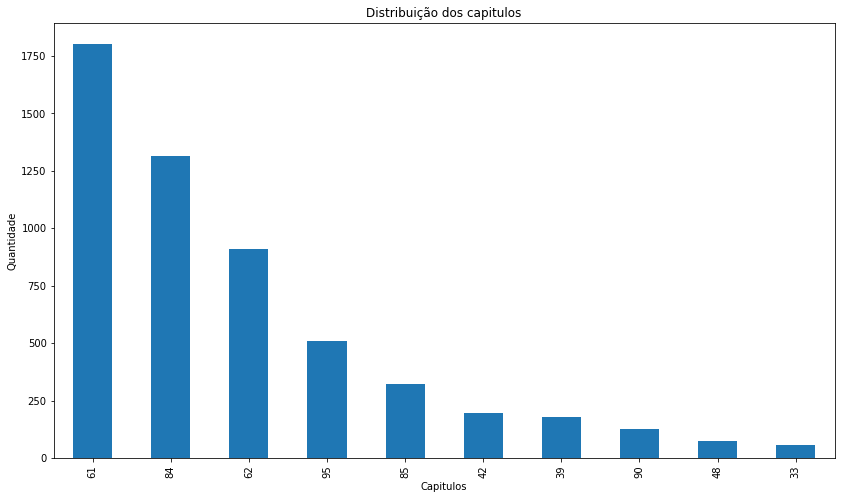

In [13]:
values = df_itens['capitulo'].value_counts()
threshold = 50
mask = values > threshold
values = values.loc[mask]

ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos capitulos")
ax.set_xlabel("Capitulos")
ax.set_ylabel("Quantidade")

### Conclusão itensTG: os capítulos maior representatividade são:'61', '84', '62', '95', '85', '42', '39', '90', '48', '33'

### 1.6.2 - Dataframe Secta - capítulos com mais de 80 itens

Text(0, 0.5, 'Quantidade')

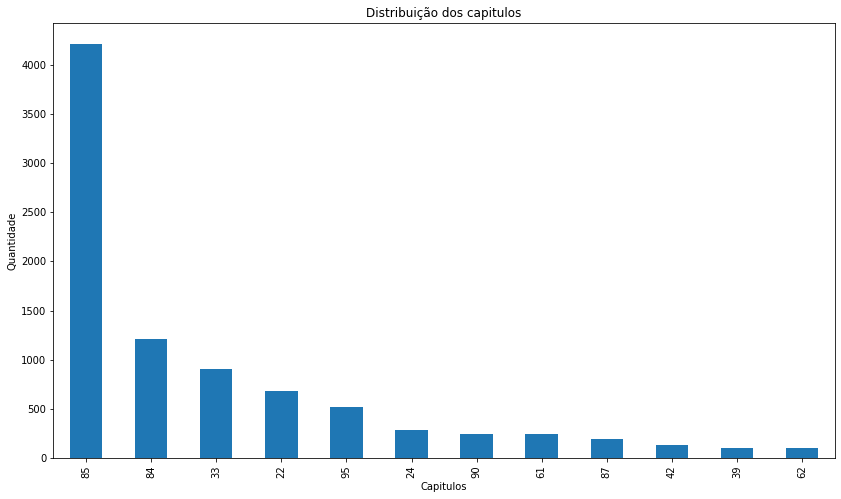

In [14]:
values = df_secta['capitulo'].value_counts()
threshold = 80
mask = values > threshold
values = values.loc[mask]

ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos capitulos")
ax.set_xlabel("Capitulos")
ax.set_ylabel("Quantidade")

### Conclusão Secta: os capítulos com maior representatividade são:'85', '84', '33', '22', '95', '24', '90', '61', '87', '42'

### Dessa forma, os capítulos comum são: 85, 84, 33, 95, 90, 61, 62 e 42

### 1.6.3 - Dataframe Itens - consolidação de ItensTG, TEC e Secta

Text(0, 0.5, 'Quantidade')

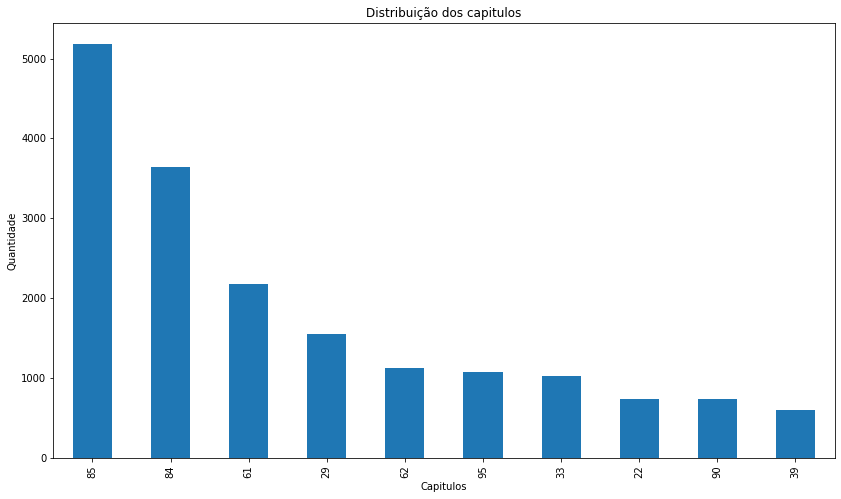

In [15]:
values = itens['capitulo'].value_counts()
threshold = 450
mask = values > threshold
values = values.loc[mask]

ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos capitulos")
ax.set_xlabel("Capitulos")
ax.set_ylabel("Quantidade")

Text(0, 0.5, 'Quantidade')

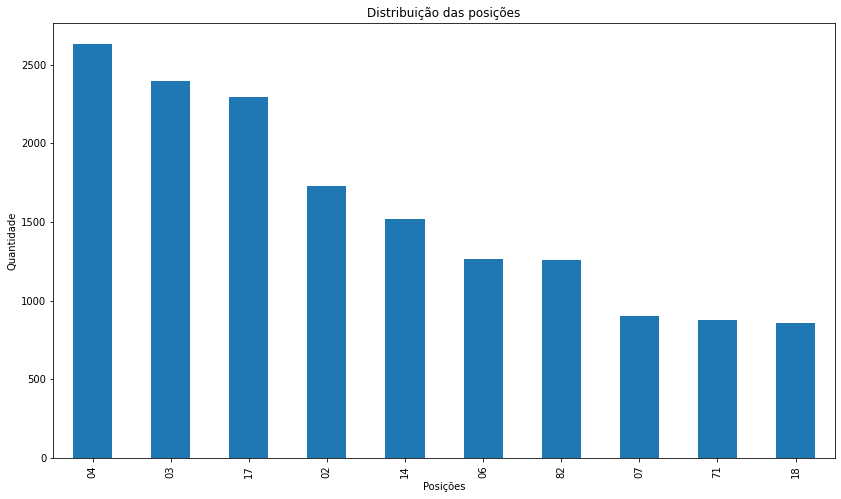

In [16]:
# Cria gráfico de barras
values = itens['posicao'].value_counts()  # conta quantidade de valores da coluna capítulo
threshold = 850  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição das posições")
ax.set_xlabel("Posições")
ax.set_ylabel("Quantidade")

Text(0, 0.5, 'Quantidade')

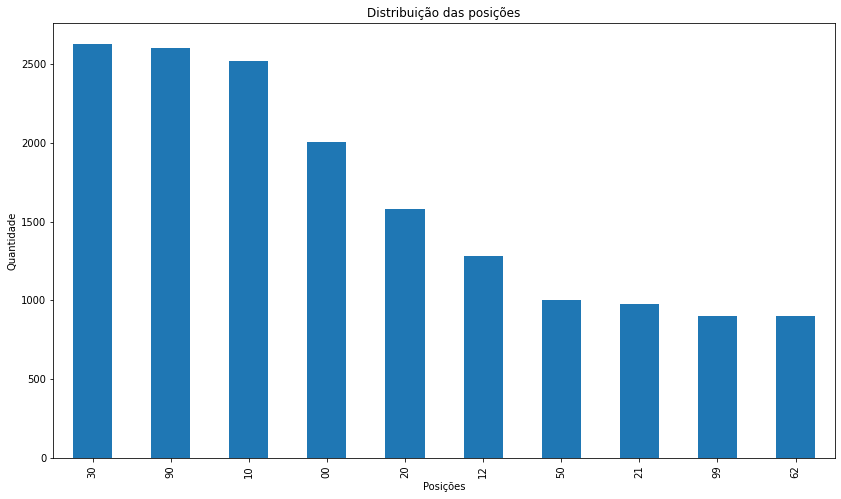

In [17]:
# Cria gráfico de barras
values = itens['subposicao'].value_counts()  # conta quantidade de valores da coluna capítulo
threshold = 850  # define limite inferior para exibição no gráfico (exibir 10 primeiros )
mask = values > threshold  
values = values.loc[mask] # pega os valores que devem ser exibidos

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição das posições")
ax.set_xlabel("Posições")
ax.set_ylabel("Quantidade")

Text(0, 0.5, 'Quantidade')

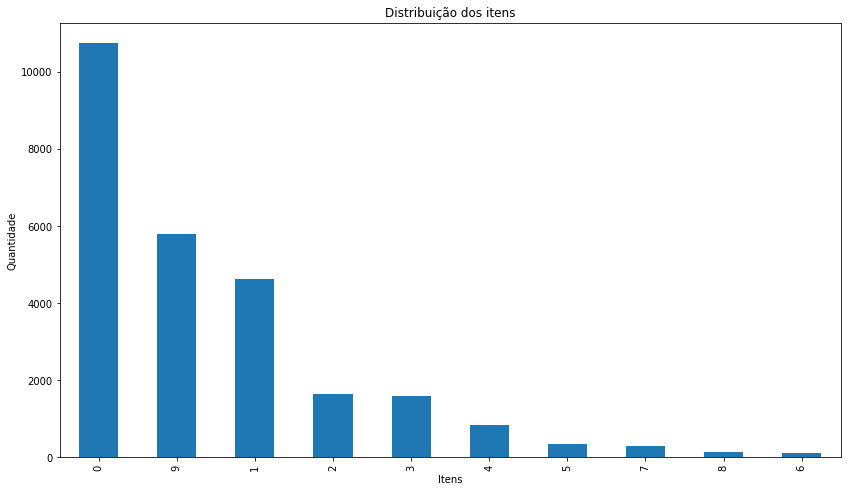

In [18]:
# Cria gráfico de barras
values = itens['item'].value_counts()  # conta quantidade de valores da coluna capítulo

# informações do gráfico
ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos itens")
ax.set_xlabel("Itens")
ax.set_ylabel("Quantidade")

Text(0, 0.5, 'Quantidade')

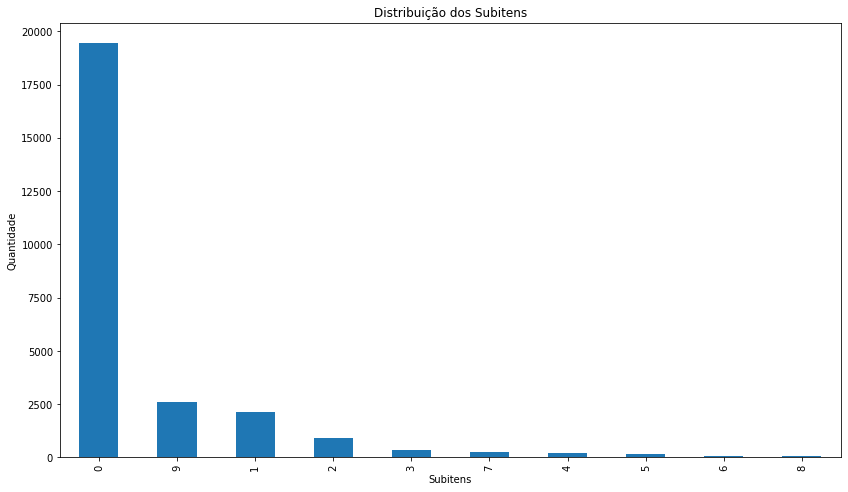

In [19]:
# Cria gráfico de barras
values = itens['subitem'].value_counts()  # conta quantidade de valores da coluna capítulo

ax = values.plot(kind='bar', figsize=(14,8), title="Distribuição dos Subitens")
ax.set_xlabel("Subitens")
ax.set_ylabel("Quantidade")

## Cria dataframes para comparar as distribuições dos Capítulos, Posições, Subposições, Itens e Subitens em todos os dataframes

In [20]:
df_comparacao_capitulo = pd.DataFrame()
df_comparacao_capitulo['itenstg capitulo'] = df_itens['capitulo'].value_counts()[:10].index
df_comparacao_capitulo['itenstg qtidd'] = df_itens['capitulo'].value_counts()[:10].values
df_comparacao_capitulo['itenstg %'] = ((df_itens['capitulo'].value_counts()[:10].values/len(df_itens))*100).round(2)

df_comparacao_capitulo['secta capitulo'] = df_secta['capitulo'].value_counts()[:10].index
df_comparacao_capitulo['secta qtidd'] = df_secta['capitulo'].value_counts()[:10].values
df_comparacao_capitulo['secta % '] = ((df_secta['capitulo'].value_counts()[:10].values/len(df_secta))*100).round(2)

df_comparacao_capitulo['tec capitulo'] = df_tec['capitulo'].value_counts()[:10].index
df_comparacao_capitulo['tec qtidd'] = df_tec['capitulo'].value_counts()[:10].values
df_comparacao_capitulo['tec %'] = ((df_tec['capitulo'].value_counts()[:10].values/len(df_tec))*100).round(2)

df_comparacao_capitulo['itens capitulo'] = itens['capitulo'].value_counts()[:10].index
df_comparacao_capitulo['itens qtidd'] = itens['capitulo'].value_counts()[:10].values
df_comparacao_capitulo['itens %'] = ((itens['capitulo'].value_counts()[:10].values/len(itens))*100).round(2)

df_comparacao_capitulo

,itenstg capitulo,itenstg qtidd,itenstg %,secta capitulo,secta qtidd,secta %,tec capitulo,tec qtidd,tec %,itens capitulo,itens qtidd,itens %
0,61,1803,30.21,85,4213,42.13,29,1519,14.97,85,5183,19.85
1,84,1317,22.07,84,1212,12.12,84,1116,11.00,84,3645,13.96
2,62,911,15.26,33,910,9.10,85,649,6.40,61,2176,8.33
3,95,511,8.56,22,682,6.82,28,409,4.03,29,1549,5.93
4,85,321,5.38,95,517,5.17,30,401,3.95,62,1133,4.34
5,42,197,3.30,24,290,2.90,90,367,3.62,95,1077,4.12
6,39,179,3.00,90,244,2.44,03,320,3.15,33,1021,3.91
7,90,126,2.11,61,241,2.41,39,313,3.08,22,742,2.84
8,48,76,1.27,87,197,1.97,38,259,2.55,90,737,2.82
9,33,58,0.97,42,137,1.37,72,212,2.09,39,596,2.28


In [21]:
df_comparacao_posicao = pd.DataFrame()
df_comparacao_posicao['itenstg posicao'] = df_itens['posicao'].value_counts()[:10].index
df_comparacao_posicao['itenstg qtidd'] = df_itens['posicao'].value_counts()[:10].values
df_comparacao_posicao['itenstg %'] = ((df_itens['posicao'].value_counts()[:10].values/len(df_itens))*100).round(2)

df_comparacao_posicao['secta posicao'] = df_secta['posicao'].value_counts()[:10].index
df_comparacao_posicao['secta qtidd'] = df_secta['posicao'].value_counts()[:10].values
df_comparacao_posicao['secta % '] = ((df_secta['posicao'].value_counts()[:10].values/len(df_secta))*100).round(2)

df_comparacao_posicao['tec posicao'] = df_tec['posicao'].value_counts()[:10].index
df_comparacao_posicao['tec qtidd'] = df_tec['posicao'].value_counts()[:10].values
df_comparacao_posicao['tec %'] = ((df_tec['posicao'].value_counts()[:10].values/len(df_tec))*100).round(2)

df_comparacao_posicao['itens posicao'] = itens['posicao'].value_counts()[:10].index
df_comparacao_posicao['itens qtidd'] = itens['posicao'].value_counts()[:10].values
df_comparacao_posicao['itens %'] = ((itens['posicao'].value_counts()[:10].values/len(itens))*100).round(2)

df_comparacao_posicao

,itenstg posicao,itenstg qtidd,itenstg %,secta posicao,secta qtidd,secta %,tec posicao,tec qtidd,tec %,itens posicao,itens qtidd,itens %
0,82,1238,20.74,17,1997,19.97,04,771,7.60,04,2631,10.07
1,14,1090,18.26,04,1192,11.92,02,758,7.47,03,2393,9.16
2,04,668,11.19,03,1054,10.54,03,730,7.19,17,2294,8.78
3,06,658,11.03,71,835,8.35,01,506,4.99,02,1730,6.62
4,03,609,10.20,18,592,5.92,07,481,4.74,14,1518,5.81
5,02,414,6.94,02,558,5.58,06,465,4.58,06,1262,4.83
6,26,161,2.70,23,395,3.95,05,462,4.55,82,1258,4.82
7,10,141,2.36,28,357,3.57,08,436,4.30,07,905,3.47
8,05,117,1.96,07,324,3.24,09,343,3.38,71,879,3.37
9,17,105,1.76,08,244,2.44,10,297,2.93,18,857,3.28


In [22]:
df_comparacao_subposicao = pd.DataFrame()
df_comparacao_subposicao['itenstg subposicao'] = df_itens['subposicao'].value_counts()[:10].index
df_comparacao_subposicao['itenstg qtidd'] = df_itens['subposicao'].value_counts()[:10].values
df_comparacao_subposicao['itenstg %'] = ((df_itens['subposicao'].value_counts()[:10].values/len(df_itens))*100).round(2)

df_comparacao_subposicao['secta subposicao'] = df_secta['subposicao'].value_counts()[:10].index
df_comparacao_subposicao['secta qtidd'] = df_secta['subposicao'].value_counts()[:10].values
df_comparacao_subposicao['secta % '] = ((df_secta['subposicao'].value_counts()[:10].values/len(df_secta))*100).round(2)

df_comparacao_subposicao['tec subposicao'] = df_tec['subposicao'].value_counts()[:10].index
df_comparacao_subposicao['tec qtidd'] = df_tec['subposicao'].value_counts()[:10].values
df_comparacao_subposicao['tec %'] = ((df_tec['subposicao'].value_counts()[:10].values/len(df_tec))*100).round(2)

df_comparacao_subposicao['itens subposicao'] = itens['subposicao'].value_counts()[:10].index
df_comparacao_subposicao['itens qtidd'] = itens['subposicao'].value_counts()[:10].values
df_comparacao_subposicao['itens %'] = ((itens['subposicao'].value_counts()[:10].values/len(itens))*100).round(2)

df_comparacao_subposicao


,itenstg subposicao,itenstg qtidd,itenstg %,secta subposicao,secta qtidd,secta %,tec subposicao,tec qtidd,tec %,itens subposicao,itens qtidd,itens %
0,30,1378,23.09,12,981,9.81,90,1390,13.70,30,2627,10.06
1,10,1004,16.82,00,976,9.76,10,981,9.67,90,2599,9.95
2,50,557,9.33,90,926,9.26,20,735,7.24,10,2517,9.64
3,00,541,9.07,62,801,8.01,00,490,4.83,00,2007,7.68
4,20,389,6.52,30,779,7.79,30,470,4.63,20,1580,6.05
5,40,372,6.23,21,716,7.16,19,455,4.48,12,1280,4.90
6,90,283,4.74,41,584,5.84,99,436,4.30,50,1001,3.83
7,63,197,3.30,10,532,5.32,29,385,3.79,21,974,3.73
8,43,125,2.09,20,456,4.56,11,348,3.43,99,901,3.45
9,92,117,1.96,70,445,4.45,39,331,3.26,62,900,3.45


In [23]:
df_comparacao_item = pd.DataFrame()

df_comparacao_item['tec item'] = df_tec['item'].value_counts().index
df_comparacao_item['tec qtidd'] = df_tec['item'].value_counts().values
df_comparacao_item['tec %'] = ((df_tec['item'].value_counts().values/len(df_tec))*100).round(2)

df_itentg_item = pd.DataFrame()
df_itentg_item['itenstg item'] = df_itens['item'].value_counts().index
df_itentg_item['itenstg qtidd'] = df_itens['item'].value_counts().values
df_itentg_item['itenstg %'] = ((df_itens['item'].value_counts().values/len(df_itens))*100).round(2)

df_comparacao_item = pd.concat([df_comparacao_item, df_itentg_item], axis=1)

df_secta_item = pd.DataFrame()
df_secta_item['secta item'] = df_secta['item'].value_counts().index
df_secta_item['secta qtidd'] = df_secta['item'].value_counts().values
df_secta_item['secta %'] = ((df_secta['item'].value_counts().values/len(df_secta))*100).round(2)

df_comparacao_item = pd.concat([df_comparacao_item, df_secta_item], axis=1)

df_comparacao_item['itens item'] = itens['item'].value_counts().index
df_comparacao_item['itens qtidd'] = itens['item'].value_counts().values
df_comparacao_item['itens %'] = ((itens['item'].value_counts().values/len(itens))*100).round(2)

df_comparacao_item


,tec item,tec qtidd,tec %,itenstg item,itenstg qtidd,itenstg %,secta item,secta qtidd,secta %,itens item,itens qtidd,itens %
0,0,3750,36.96,0,3560.0,59.65,0,3422,34.22,0,10732,41.09
1,1,2269,22.36,9,1768.0,29.62,9,2341,23.41,9,5794,22.18
2,9,1683,16.59,1,296.0,4.96,1,2063,20.63,1,4628,17.72
3,2,1168,11.51,2,278.0,4.66,3,1020,10.20,2,1646,6.30
4,3,524,5.16,3,59.0,0.99,4,551,5.51,3,1603,6.14
5,4,287,2.83,4,4.0,0.07,7,214,2.14,4,842,3.22
6,5,182,1.79,5,2.0,0.03,2,200,2.00,5,336,1.29
7,6,109,1.07,7,1.0,0.02,5,152,1.52,7,291,1.11
8,8,99,0.98,NaN,NaN,NaN,8,36,0.36,8,135,0.52
9,7,76,0.75,NaN,NaN,NaN,6,1,0.01,6,110,0.42


In [24]:
df_comparacao_subitem = pd.DataFrame()

df_comparacao_subitem['itenstg subitem'] = df_itens['subitem'].value_counts()[:10].index
df_comparacao_subitem['itenstg qtidd'] = df_itens['subitem'].value_counts()[:10].values
df_comparacao_subitem['itenstg %'] = ((df_itens['subitem'].value_counts()[:10].values/len(df_itens))*100).round(2)

df_comparacao_subitem['tec subitem'] = df_tec['subitem'].value_counts()[:10].index
df_comparacao_subitem['tec qtidd'] = df_tec['subitem'].value_counts()[:10].values
df_comparacao_subitem['tec %'] = ((df_tec['subitem'].value_counts()[:10].values/len(df_tec))*100).round(2)

df_secta_subitem = pd.DataFrame()
df_secta_subitem['secta subitem'] = df_secta['subitem'].value_counts().index
df_secta_subitem['secta qtidd'] = df_secta['subitem'].value_counts().values
df_secta_subitem['secta %'] = ((df_secta['subitem'].value_counts().values/len(df_secta))*100).round(2)

df_comparacao_subitem = pd.concat([df_comparacao_subitem, df_secta_subitem], axis=1)

df_comparacao_subitem['itens subitem'] = itens['subitem'].value_counts().index
df_comparacao_subitem['itens qtidd'] = itens['subitem'].value_counts().values
df_comparacao_subitem['itens %'] = ((itens['subitem'].value_counts().values/len(itens))*100).round(2)

df_comparacao_subitem


,itenstg subitem,itenstg qtidd,itenstg %,tec subitem,tec qtidd,tec %,secta subitem,secta qtidd,secta %,itens subitem,itens qtidd,itens %
0,0,5292,88.67,0,7250,71.45,0,6896.0,68.96,0,19438,74.43
1,9,298,4.99,1,861,8.49,9,1481.0,14.81,9,2602,9.96
2,2,209,3.50,9,821,8.09,1,1182.0,11.82,1,2109,8.08
3,7,97,1.63,2,487,4.80,2,214.0,2.14,2,910,3.48
4,1,66,1.11,3,282,2.78,7,106.0,1.06,3,343,1.31
5,3,2,0.03,4,164,1.62,3,59.0,0.59,7,258,0.99
6,8,1,0.02,5,111,1.09,5,28.0,0.28,4,191,0.73
7,4,1,0.02,6,75,0.74,4,26.0,0.26,5,140,0.54
8,5,1,0.02,7,55,0.54,8,8.0,0.08,6,76,0.29
9,6,1,0.02,8,41,0.40,NaN,NaN,NaN,8,50,0.19


## Conclusão: a junção dos três dataframes manteve aproximadamente a mesma ditribuição de representatividade por capítulos das bases de ItensTG e do Secta

### 1.7 - Salva arquivo parquet

In [25]:
itens.describe()

,descricao,ncm,ncm_str,capitulo,posicao,subposicao,item,subitem,descricao_limpa
count,26117,26117,26117,26117,26117,26117,26117,26117,26117
unique,24147,10518,10181,97,90,91,10,10,23925
top,BRINQUEDOS BRINQUEDO,61143000,61143000,85,04,30,0,0,brinquedos brinquedo
freq,75,1050,1117,5183,2631,2627,10732,19438,75


In [26]:
len(itens)

26117

In [27]:
itens = itens[['descricao_limpa', 'capitulo', 'posicao', 'subposicao', 'item', 'subitem']]

In [28]:
itens.head()

,descricao_limpa,capitulo,posicao,subposicao,item,subitem
0,mascara facial hidratante em embalagem de 25ml...,33,04,99,1,0
1,dioctil ftalato em flexi bag d c 20 toneladas ...,29,17,32,0,0
2,sola de calcado de borracha n 39 a ref xl belf...,64,06,20,0,0
3,sola de calcado de borracha n 40 a ref xl lyon mx,64,06,20,0,0
4,sola de calcado de borracha n 39 a ref xl lyon mx,64,06,20,0,0


## Descrição limpa

In [29]:
text = {}
for linha in itens.descricao_limpa:
    for palavra in linha.split(' '):
        if text.get(palavra):
            text[palavra] += 1
        else:
            text[palavra] = 1
text = dict(sorted(text.items(), key=lambda item: item[1],reverse=True))

In [30]:
for i, k in enumerate(text.keys()):
    if i <= 50:
        print(k, end=', ')
    else:
        break

de, e, ou, outros, para, a, em, nao, marca, outras, aparelhos, com, da, os, seus, incluindo, produtos, imitacao, por, mesmo, exceto, maquinas, do, que, ref, poliester, derivados, eletronicos, dci, as, telefones, superior, semelhantes, das, contenham, xiaomi, sais, posicoes, partes, informatica, sem, rolamento, celular, posicao, feminino, materias, feminina, algodao, 100, malha, nem, 

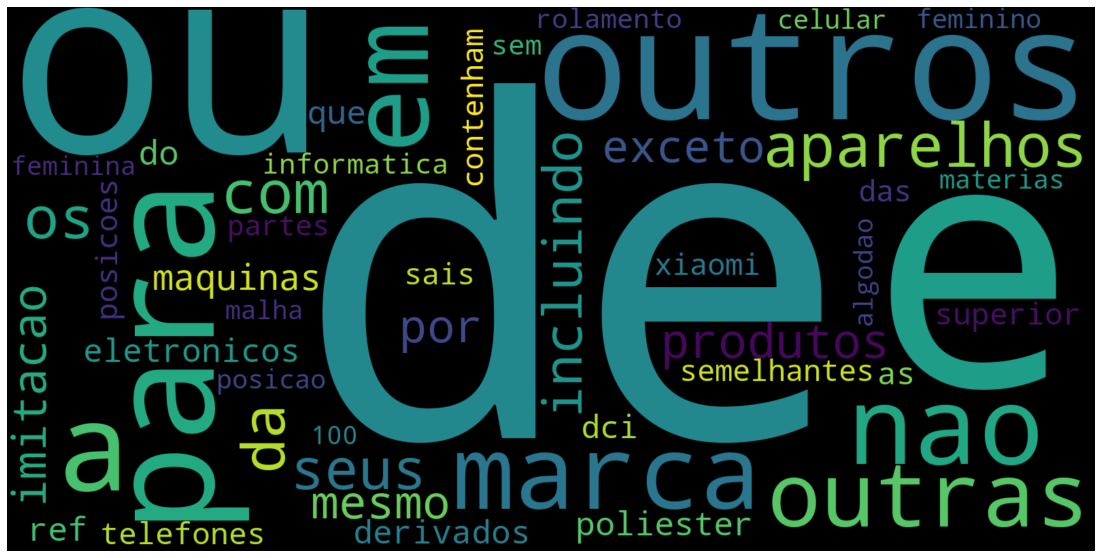

In [31]:
# Nuvem de palavras (50 mais frequentes)
wordcloud = WordCloud(width=1600, height=800, max_words=50).generate_from_frequencies(text)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [32]:
# Cria dataframe com as 50 palavras mais frequentes
df_word_count = pd.DataFrame()
df_word_count['descricao_limpa'] = text.keys()

In [33]:
itens.to_parquet('itens_desc_limpa.parquet')  # salva em formato parquet

## 2 - Dataframe com descrição limpa, sem stopwords (com afixos)

In [34]:
# Carrega os dataframes
df_itens = pd.read_parquet('1_itenstg_desc_limpa_sem_stopwords.parquet')
df_tec = pd.read_parquet('2_tec_desc_limpa_sem_stopwords.parquet')
df_secta = pd.read_parquet('3_secta_desc_limpa_sem_stopwords.parquet')

In [35]:
df_secta = df_secta.sample(n=10_000, random_state=1)

In [36]:
itens = pd.concat([df_itens, df_tec, df_secta])

In [37]:
itens.head()

,descricao,ncm,ncm_str,capitulo,posicao,subposicao,item,subitem,descricao_limpa,descricao_limpa_sem_stopwords
0,MÁSCARA FACIAL HIDRATANTE EM EMBALAGEM DE 25ML...,33049910,33049910,33,04,99,1,0,mascara facial hidratante em embalagem de 25ml...,mascara facial hidratante embalagem 25ml days ...
1,DIOCTIL FTALATO EM FLEXI-BAG D/C 20 TONELADAS ...,29173200,29173200,29,17,32,0,0,dioctil ftalato em flexi bag d c 20 toneladas ...,dioctil ftalato flexi bag d 20 toneladas metri...
2,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL B...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 39 a ref xl belf...,sola calcado borracha belfast mx
3,"SOLA DE CALÇADO, DE BORRACHA, N 40 A, REF XL L...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 40 a ref xl lyon mx,sola calcado borracha lyon mx
4,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL L...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 39 a ref xl lyon mx,sola calcado borracha lyon mx


In [38]:
itens = itens[['descricao_limpa_sem_stopwords', 'capitulo', 'posicao', 'subposicao', 'item', 'subitem']]

In [39]:
text = {}
for linha in itens.descricao_limpa_sem_stopwords:
    for palavra in linha.split(' '):
        if text.get(palavra):
            text[palavra] += 1
        else:
            text[palavra] = 1
text = dict(sorted(text.items(), key=lambda item: item[1],reverse=True))

In [40]:
for i, k in enumerate(text.keys()):
    if i <= 50:
        print(k, end=', ')
    else:
        break

outros, nao, outras, aparelhos, incluindo, produtos, imitacao, exceto, maquinas, poliester, derivados, dci, telefones, superior, semelhantes, contenham, sais, posicoes, partes, informatica, rolamento, celular, posicao, feminino, materias, algodao, feminina, malha, artigos, peixes, peso, smartphone, compostos, preparacoes, fibras, spp, blusa, 84, fios, elastano, bebidas, papel, tecidos, acessorios, halogenados, destes, exemplo, telefone, formas, acidos, uso, 

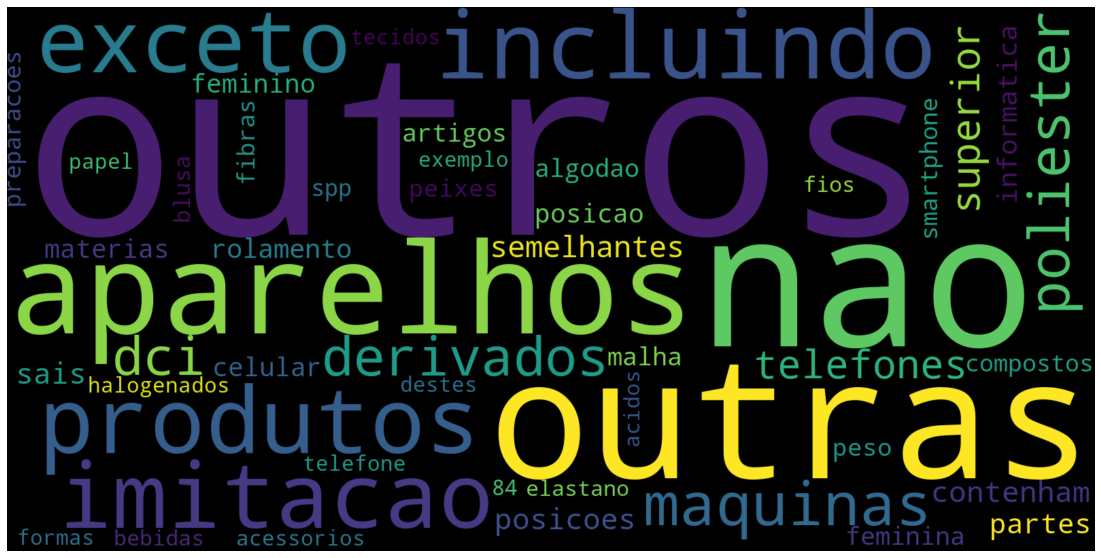

In [41]:
# Nuvem de palavras (50 mais frequentes)
wordcloud = WordCloud(width=1600, height=800, max_words=50).generate_from_frequencies(text)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [42]:
df_word_count_sem_stopwords = pd.DataFrame()
df_word_count_sem_stopwords['descricao_limpa_sem_stopwords'] = text.keys()
df_word_count = pd.concat([df_word_count, df_word_count_sem_stopwords], axis=1)

In [43]:
itens.to_parquet('itens_desc_limpa_sem_stopwords.parquet')  # salva em formato parquet

## 3 - Dataframe com descrição limpa, sem stopwords e radicais das palavras (stemming)

In [44]:
# Carrega os dataframes
df_itens = pd.read_parquet('1_itenstg_desc_limpa_sem_stopwords_stemming.parquet')
df_tec = pd.read_parquet('2_tec_desc_limpa_sem_stopwords_stemming.parquet')
df_secta = pd.read_parquet('3_secta_desc_limpa_sem_stopwords_stemming.parquet')

In [45]:
df_secta = df_secta.sample(n=10_000, random_state=1)

In [46]:
itens = pd.concat([df_itens, df_tec, df_secta])

In [47]:
itens.head()

,descricao,ncm,ncm_str,capitulo,posicao,subposicao,item,subitem,descricao_limpa,descricao_limpa_sem_stopwords,descricao_limpa_stemming,descricao_limpa_sem_stopwords_stemming
0,MÁSCARA FACIAL HIDRATANTE EM EMBALAGEM DE 25ML...,33049910,33049910,33,04,99,1,0,mascara facial hidratante em embalagem de 25ml...,mascara facial hidratante embalagem 25ml days ...,masc fac hidrat em embal de 25ml 5 day dre mir...,masc fac hidrat embal 25ml day dre miracl vali...
1,DIOCTIL FTALATO EM FLEXI-BAG D/C 20 TONELADAS ...,29173200,29173200,29,17,32,0,0,dioctil ftalato em flexi bag d c 20 toneladas ...,dioctil ftalato flexi bag d 20 toneladas metri...,dioctil ftalat em flex bag d c 20 tonel metr d...,dioctil ftalat flex bag d 20 tonel metr diocty...
2,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL B...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 39 a ref xl belf...,sola calcado borracha belfast mx,sol de calc de borrach n 39 a ref xl belfast mx,sol calc borrach belfast mx
3,"SOLA DE CALÇADO, DE BORRACHA, N 40 A, REF XL L...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 40 a ref xl lyon mx,sola calcado borracha lyon mx,sol de calc de borrach n 40 a ref xl lyon mx,sol calc borrach lyon mx
4,"SOLA DE CALÇADO, DE BORRACHA, N 39 A, REF XL L...",64062000,64062000,64,06,20,0,0,sola de calcado de borracha n 39 a ref xl lyon mx,sola calcado borracha lyon mx,sol de calc de borrach n 39 a ref xl lyon mx,sol calc borrach lyon mx


In [48]:
itens = itens[['descricao_limpa_sem_stopwords_stemming', 'capitulo', 'posicao', 'subposicao', 'item', 'subitem']]

In [49]:
text = {}
for linha in itens.descricao_limpa_sem_stopwords_stemming:
    for palavra in linha.split(' '):
        if text.get(palavra):
            text[palavra] += 1
        else:
            text[palavra] = 1
text = dict(sorted(text.items(), key=lambda item: item[1],reverse=True))

In [50]:
for i, k in enumerate(text.keys()):
    if i <= 50:
        print(k, end=', ')
    else:
        break

outr, nao, aparelh, inclu, produt, imitaca, telefon, maquin, excet, feminin, poliest, deriv, dci, rol, superi, semelh, sal, part, contenh, posico, celul, fio, informa, tec, mat, perfum, acid, posica, malh, algoda, artig, peix, form, pes, fibr, red, uso, dest, compost, smartphon, preparaco, spp, blus, papel, eletr, metal, beb, 84, elast, plan, acessori, 

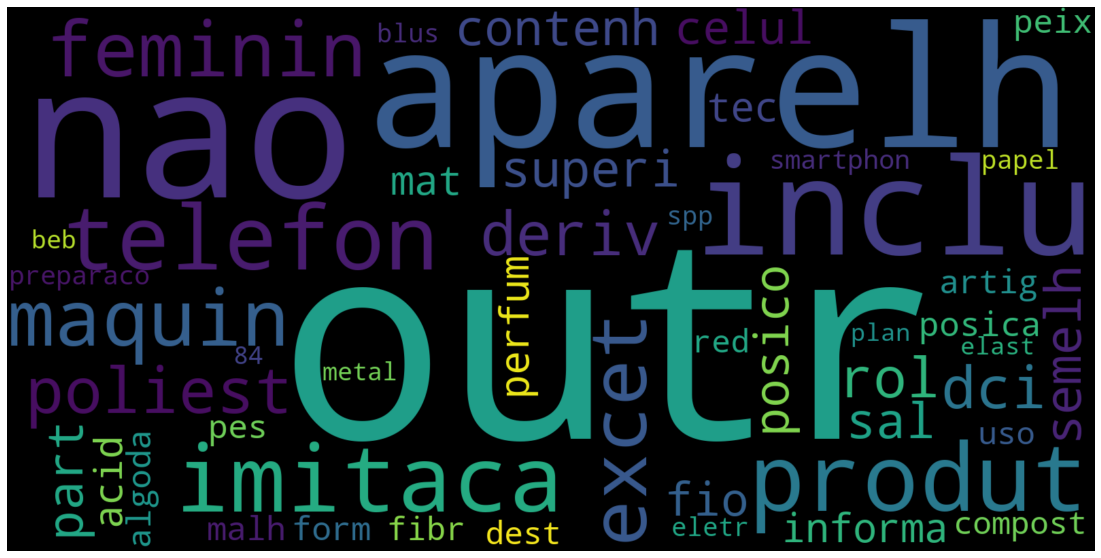

In [51]:
# Nuvem de palavras (50 mais frequentes)
wordcloud = WordCloud(width=1600, height=800, max_words=50).generate_from_frequencies(text)
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()

In [52]:
df_word_count_stemming = pd.DataFrame()
df_word_count_stemming['descricao_limpa_sem_stopwords_stemming'] = text.keys()
df_word_count = pd.concat([df_word_count, df_word_count_stemming], axis=1)

In [53]:
df_word_count.head(20)

,descricao_limpa,descricao_limpa_sem_stopwords,descricao_limpa_sem_stopwords_stemming
0,de,outros,outr
1,e,nao,nao
2,ou,outras,aparelh
3,outros,aparelhos,inclu
4,para,incluindo,produt
5,a,produtos,imitaca
6,em,imitacao,telefon
7,nao,exceto,maquin
8,marca,maquinas,excet
9,outras,poliester,feminin


In [54]:
itens.to_parquet('itens_desc_limpa_sem_stopwords_stemming.parquet')  # salva em formato parquet